In [ ]:
import json

import kagglehub

import tensorflow as tf
from keras import Sequential, Input
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import random

import seaborn as sns

from sklearn import preprocessing

from sklearn.metrics import classification_report, confusion_matrix



# Set random state for reproducibility
random_state = 42
random.seed(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

In [ ]:
# IF YOU ARE NOT USING KAGGLE
BASE_PATH = kagglehub.dataset_download("mattiaingrassia/gtzan-2-0")+"/"
# IF YOU ARE USING KAGGLE, ADD THE DATASET TO THE NOTEBOOOK, COMMENT THE PREVIOUS LINE AND UNCOMMENT THE FOLLOWING ONE
# BASE_PATH = "/kaggle/input/gtzan-2-0/"

In [ ]:
# model evaluation
def create_report(y_true, preds):
    y_true_int = np.argmax(y_true, axis = 1)
    preds_int = np.argmax(preds, axis = 1)
    report = classification_report(y_true_int, preds_int, output_dict = True)
    print(report)
    return report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

# Plot functions
sns.set_style("darkgrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 11

train_color = "#2E86AB"  # Deep blue
val_color = "#A23B72"    # Deep magenta

color_palette = ["#a6cee3", "#1f78b4","#e31a1c", "#33a02c"]
model_versions = ["0.0", "1.0", "1.1", "1.2"]
model_color_map = dict(zip(model_versions, color_palette))

def plot_loss(history):
    loss = history.history.get("loss")
    val_loss = history.history.get("val_loss")
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 6))

    plt.plot(epochs, loss, linewidth=2.5, label="Training Loss", color=train_color, marker='o', markersize=4, alpha=0.8)
    plt.plot(epochs, val_loss, linewidth=2.5, label="Validation Loss", color=val_color, marker='s', markersize=4, alpha=0.8)

    plt.title("Model Loss Over Training", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=12, fontweight='semibold')
    plt.ylabel("Loss", fontsize=12, fontweight='semibold')
    plt.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)
    plt.grid(True, alpha=0.5, linestyle='--')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_accuracy(history):
    acc = history.history.get("accuracy")
    val_acc = history.history.get("val_accuracy")
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, acc, linewidth=2.5, label="Training Accuracy", color=train_color, marker='o', markersize=4, alpha=0.8)
    plt.plot(epochs, val_acc, linewidth=2.5, label="Validation Accuracy", color=val_color, marker='s', markersize=4, alpha=0.8)

    plt.title("Model Accuracy Over Training", fontsize=14, fontweight='bold', pad=15)
    plt.xlabel("Epoch", fontsize=12, fontweight='semibold')
    plt.ylabel("Accuracy", fontsize=12, fontweight='semibold')
    plt.ylim(0, 1.01)
    plt.legend(loc='lower right', frameon=True, shadow=True, fontsize=11)
    plt.grid(True, alpha=0.5, linestyle='--')

    ax = plt.gca()
    ax.set_yticks(np.arange(0.1, 1.01, 0.1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_test, y_pred, model_version):
    y_test = np.argmax(y_test, axis=1)
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm,
        xticklabels=GENRES,
        yticklabels=GENRES,
        cmap="mako",
        annot=True,
        fmt="d"
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Model {model_version}")
    plt.tight_layout()
    plt.show()

def plot_classwise_metrics(classification_dict, model_version, color):
    classes = [str(i) for i in range(NUM_CLASSES)]
    
    precision = [classification_dict[c]["precision"] for c in classes]
    recall = [classification_dict[c]["recall"] for c in classes]
    f1 = [classification_dict[c]["f1-score"] for c in classes]

    x = np.arange(NUM_CLASSES)

    metrics = {
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    for metric_name, values in metrics.items():
        plt.figure(figsize=(12, 6))
        plt.bar(x, values, color=color, edgecolor="#222222")
        plt.xticks(x, GENRES, rotation=90)
        plt.ylim(0, 1.01)
        ax = plt.gca()
        ax.set_yticks(np.arange(0.1, 1.0, 0.1))
        plt.xlabel("Class")
        plt.ylabel(metric_name)
        plt.title(f"Class-wise {metric_name} - Model {model_version}")
        plt.grid(axis="y", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

def plot_overall_metrics(model_metrics, model_version):
    metric_names = ["accuracy", "precision", "recall", "f1-score"]
    values = [model_metrics[m] for m in metric_names]
    plt.figure(figsize=(8, 6))
    plt.bar(metric_names, values, color=model_color_map[model_version], edgecolor="#222222")
    plt.ylim(0, 1.01)
    ax = plt.gca()
    ax.set_yticks(np.arange(0.1, 1.0, 0.1))
    plt.ylabel("Score")
    plt.title(f"Overall Performance Metrics - Model {model_version}")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_model_performance_radar(models_performances):
    metrics = ["accuracy", "precision", "recall", "f1-score"]
    num_metrics = len(metrics)

    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the circle

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([m.capitalize() for m in metrics])
    ax.tick_params(axis='x', pad=15)

    
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.7, 0.8, 1])

    for model_name, scores in models_performances.items():
        version = model_name[-3:]
        values = [scores[m] for m in metrics]
        values += values[:1]

        ax.plot(angles, values, color=model_color_map[version], linewidth=2, label=model_name)
        ax.fill(angles, values, alpha=0.1)
    

    ax.set_title("Model Performance Comparison", pad=45)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

    plt.tight_layout()
    plt.show()

def create_naive_CNN_archi(model_version, learning_rate=1e-4):
    model = Sequential([
            Input(shape=(NUM_TIMESTEPS, NUM_FEATURES)),
            LSTM(256, return_sequences=True),
            LSTM(256, return_sequences=True),
            LSTM(128, return_sequences=False),
            Dense(NUM_CLASSES, activation="softmax"),
        ], name=model_version)
    
    model.summary()
    
    model.compile(
       metrics = ["accuracy"],
       loss = "categorical_crossentropy",
       optimizer = Adam(learning_rate=learning_rate)
    )
    
    return model

def create_improved_RNN_archi(model_version, learning_rate=1e-4):
    model = Sequential([
            Input(shape=(NUM_TIMESTEPS, NUM_FEATURES)),
            Dropout(0.2),
            LSTM(64, return_sequences=True),
            Dropout(0.3),
            LSTM(32, return_sequences=True),
            Dropout(0.3),
            LSTM(16, return_sequences=False),
            Dropout(0.3),
            Dense(NUM_CLASSES, activation="softmax"),
        ], name=model_version)
    
    model.summary()
    
    model.compile(
       metrics = ["accuracy"],
       loss = "categorical_crossentropy",
       optimizer = Adam(learning_rate=learning_rate)
    )
    
    return model

def fit_and_get_report(model, X_train, y_train, X_test, y_test, X_val, y_val, epochs = 600, patience = None):
    callbacks = []
    
    if patience != None:
        callbacks.append(EarlyStopping(patience=patience, monitor="val_loss", restore_best_weights=True))
    
    history = model.fit(
       X_train, y_train,
       batch_size = 64,
       epochs = epochs,
       validation_data = (X_val, y_val),
       callbacks = callbacks
    )
    plot_accuracy(history)
    plot_loss(history)


    y_pred = model.predict(X_test)
    y_pred_int = np.argmax(y_pred, axis = 1)


    plot_confusion_matrix(y_test, y_pred_int, model.name)
    return create_report(y_test, y_pred)

# Data Load and Preparation

In [ ]:
# Load the dataset
data = pd.read_csv(BASE_PATH + "features_3_sec.csv")

# Define some variables used for data preparation.
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES = len(GENRES)
NUM_TIMESTEPS = 10

performances = {}

data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
# Remove the rows corresponding to the missing image
jazz_to_remove = [f"jazz.00054.{i}.wav" for i in range(10)]
data = data[~data["filename"].isin(jazz_to_remove)]

# Divide data in 'labels' and 'features'
y_labels = data['label'].to_list()

# Remove unncecessary features and get filenames
X = data.drop(columns=["length", "label"])
X_filename = X['filename'].to_numpy()
X_features = X.drop(columns=["filename"]).to_numpy()
NUM_FEATURES = len(X_features[0])

The follwing snippet saves in X and y the various instances in the CSV.
It also adds dummy rows in the instances where the last audio extract is missing to make data consistent.

In [ ]:
# The original dataset contains 10 rows per instance, each corresponding to a timestep;
# here we aggregate them into a 3D tensor of shape (999 instances × 10 timesteps × 57 features)
# to be used as input for the RNN.

# Allocate the needed memory
X = np.zeros((999, NUM_TIMESTEPS, NUM_FEATURES))
y = np.zeros((999))

instance_index = -1
skip_offset = 0
prev_timestep = 10

# Group up rows so that each group represents an audio file
for name in X_filename:
    split_name = name.split(".")
    
    # Get the genre and timestamp of the current instance
    cur_genre = split_name[0]
    cur_timestep = int(split_name[2])
    if cur_timestep == 0: # New instance
        
        # If the number of timesteps of the previous instance is less than 10
        if prev_timestep == 8:
            skip_offset += 1
            
            # Infer the last timestep by using the mean of the previous ones
            X[instance_index, 9,:] = np.mean(X[instance_index, 0:9, :], axis = 0)
        instance_index += 1
        
    # Update the timestep
    prev_timestep = cur_timestep
        
    X[instance_index, cur_timestep, :] = X_features[instance_index * 10 + cur_timestep - skip_offset, :]
    y[instance_index] = GENRES.index(cur_genre)

Load train, validation and test sets by recovering the indices of their instances in a JSON file instead of extracting them from X. This allows us to have the same training, validation and test instances for both the CNN and RNN models.

In [ ]:
def get_X_y(indices_path, X, y):

    # Read indices
    with open(indices_path, "r") as file:
        indices = json.load(file)

    # Allocate needed memory
    X_ret = np.zeros((len(indices), NUM_TIMESTEPS, NUM_FEATURES))
    y_ret = np.zeros((len(indices)))
    
    i = 0
    for index, _ in indices:
        X_ret[i] = X[index]
        y_ret[i] = y[index]
        i = i + 1
    
    return X_ret, y_ret

In [ ]:
X_train, y_train = get_X_y(BASE_PATH + "indices_train.json", X, y)
X_test, y_test = get_X_y(BASE_PATH + "indices_test.json", X, y)
X_val, y_val = get_X_y(BASE_PATH + "indices_val.json", X, y)

(719, 10, 57)


In [97]:
# Set y to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Model 0.0: Baseline model.
Baseline model trained on non-normalized data.

In [ ]:
model_version = "0.0"
model_name = 'Model - ' + model_version

model = create_naive_CNN_archi(model_version=model_version)

Model: "0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                  │ (None, 10, 256)        │       321,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,258 (3.99 MB)

 Trainable params: 1,045,258 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.1390 - loss: 2.2952 - val_accuracy: 0.2125 - val_loss: 2.2563
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2176 - loss: 2.2373 - val_accuracy: 0.1250 - val_loss: 2.2271
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1861 - loss: 2.2069 - val_accuracy: 0.1375 - val_loss: 2.1998
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2312 - loss: 2.1632 - val_accuracy: 0.1875 - val_loss: 2.1649
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2653 - loss: 2.1111 - val_accuracy: 0.1625 - val_loss: 2.1309
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2860 - loss: 2.0604 - val_accuracy: 0.1500 - val_loss: 2.1002
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2870 - loss: 2.0169 - val_accuracy: 0.1500 - val_loss: 2.0911
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2747 - loss: 1.9787 - val_accuracy: 0.

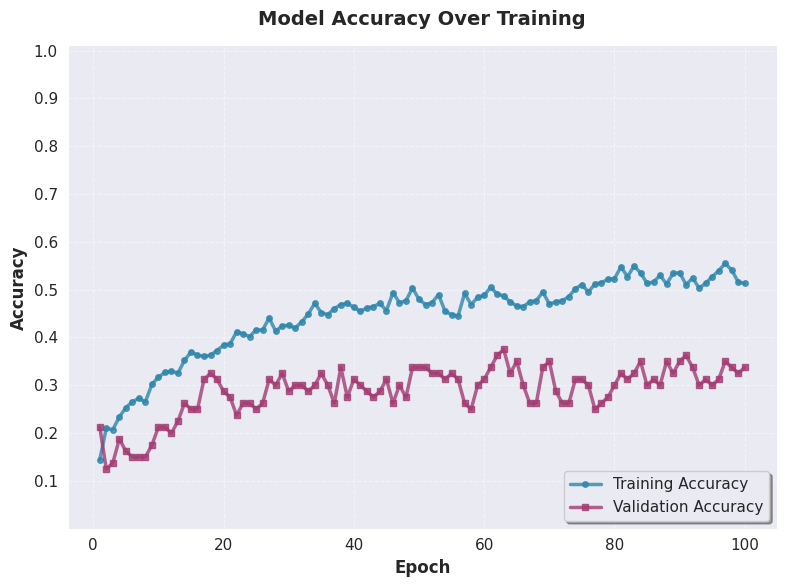

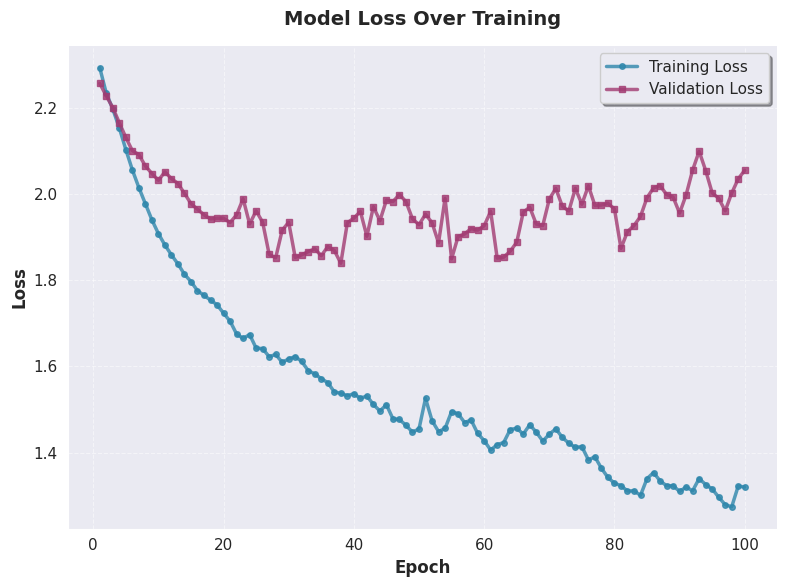

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


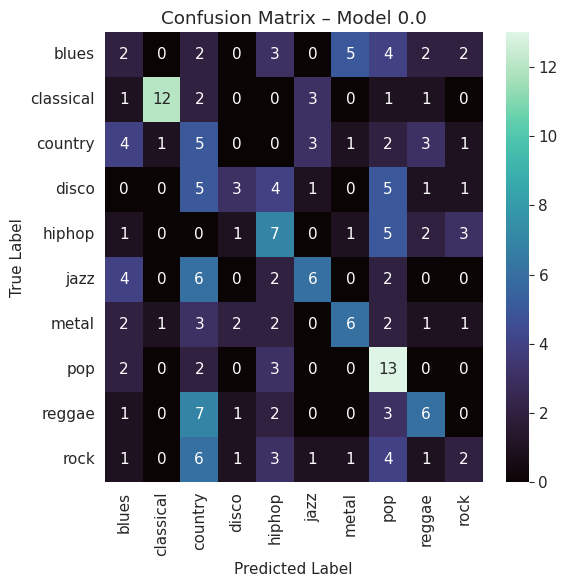

{'0': {'precision': 0.1111111111111111, 'recall': 0.1, 'f1-score': 0.10526315789473684, 'support': 20.0}, '1': {'precision': 0.8571428571428571, 'recall': 0.6, 'f1-score': 0.7058823529411765, 'support': 20.0}, '2': {'precision': 0.13157894736842105, 'recall': 0.25, 'f1-score': 0.1724137931034483, 'support': 20.0}, '3': {'precision': 0.375, 'recall': 0.15, 'f1-score': 0.21428571428571427, 'support': 20.0}, '4': {'precision': 0.2692307692307692, 'recall': 0.35, 'f1-score': 0.30434782608695654, 'support': 20.0}, '5': {'precision': 0.42857142857142855, 'recall': 0.3, 'f1-score': 0.35294117647058826, 'support': 20.0}, '6': {'precision': 0.42857142857142855, 'recall': 0.3, 'f1-score': 0.35294117647058826, 'support': 20.0}, '7': {'precision': 0.3170731707317073, 'recall': 0.65, 'f1-score': 0.4262295081967213, 'support': 20.0}, '8': {'precision': 0.35294117647058826, 'recall': 0.3, 'f1-score': 0.32432432432432434, 'support': 20.0}, '9': {'precision': 0.2, 'recall': 0.1, 'f1-score': 0.133333333

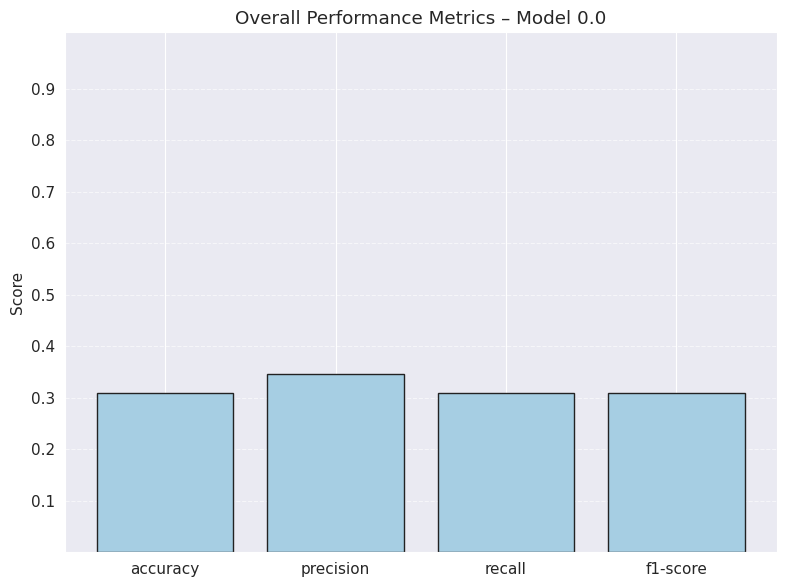

In [99]:
# Fit the model and get the report
accuracy, precision, recall, f1_score = fit_and_get_report(model, X_train, y_train, X_test, y_test, X_val, y_val, epochs = 100)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

# Model 1.0: Advanced Architecture
Advanced model trained on non-normalized data.

In [ ]:
model_version = "1.0"
model_name = 'Model - ' + model_version

model = create_improved_RNN_archi(model_version=model_version)

Model: "1.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 10, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 10, 64)         │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,954 (183.41 KB)

 Trainable params: 46,954 (183.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.1017 - loss: 2.3224 - val_accuracy: 0.1250 - val_loss: 2.3127
Epoch 2/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0904 - loss: 2.3171 - val_accuracy: 0.1375 - val_loss: 2.3108
Epoch 3/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0898 - loss: 2.3154 - val_accuracy: 0.1375 - val_loss: 2.3103
Epoch 4/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0892 - loss: 2.3090 - val_accuracy: 0.1500 - val_loss: 2.3083
Epoch 5/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0892 - loss: 2.3193 - val_accuracy: 0.1500 - val_loss: 2.3070
Epoch 6/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0813 - loss: 2.3128 - val_accuracy: 0.1500 - val_loss: 2.3057
Epoch 7/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1051 - loss: 2.3110 - val_accuracy: 0.1500 - val_loss: 2.3049
Epoch 8/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0899 - loss: 2.3063 - val_accuracy: 0.

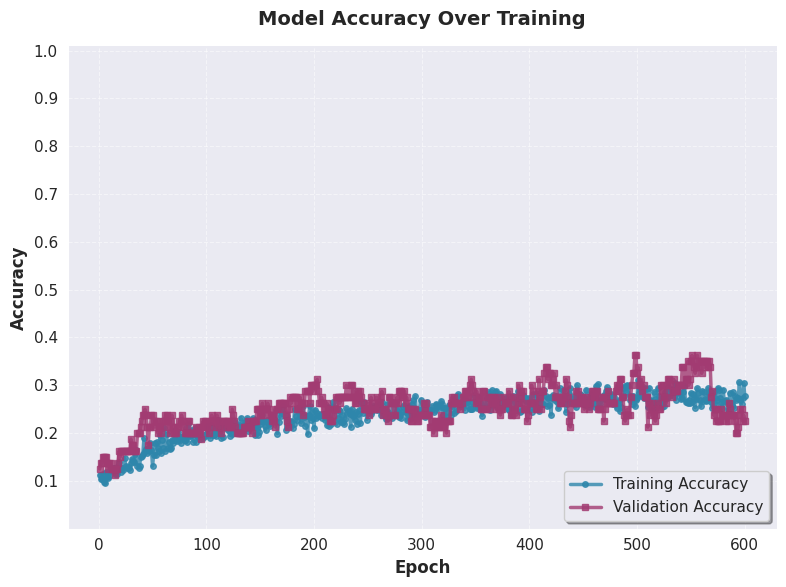

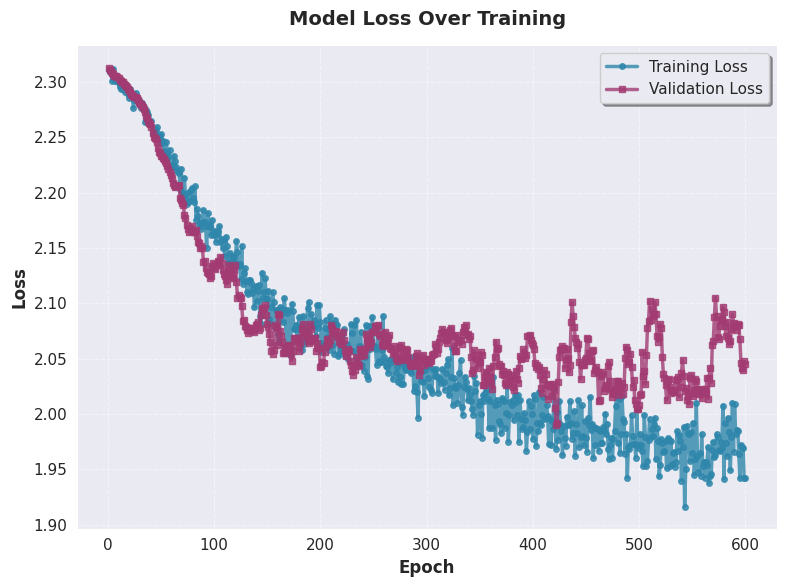

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


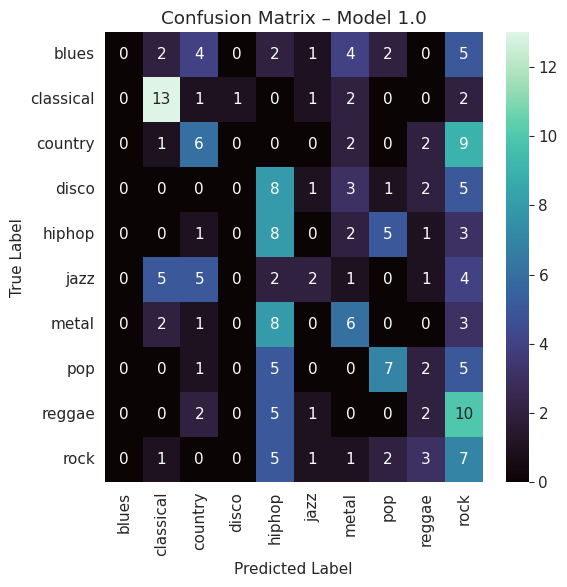

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, '1': {'precision': 0.5416666666666666, 'recall': 0.65, 'f1-score': 0.5909090909090909, 'support': 20.0}, '2': {'precision': 0.2857142857142857, 'recall': 0.3, 'f1-score': 0.2926829268292683, 'support': 20.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, '4': {'precision': 0.18604651162790697, 'recall': 0.4, 'f1-score': 0.25396825396825395, 'support': 20.0}, '5': {'precision': 0.2857142857142857, 'recall': 0.1, 'f1-score': 0.14814814814814814, 'support': 20.0}, '6': {'precision': 0.2857142857142857, 'recall': 0.3, 'f1-score': 0.2926829268292683, 'support': 20.0}, '7': {'precision': 0.4117647058823529, 'recall': 0.35, 'f1-score': 0.3783783783783784, 'support': 20.0}, '8': {'precision': 0.15384615384615385, 'recall': 0.1, 'f1-score': 0.12121212121212122, 'support': 20.0}, '9': {'precision': 0.1320754716981132, 'recall': 0.35, 'f1-score': 0.1917808219178082, 'support': 20.0}, 'accuracy':

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


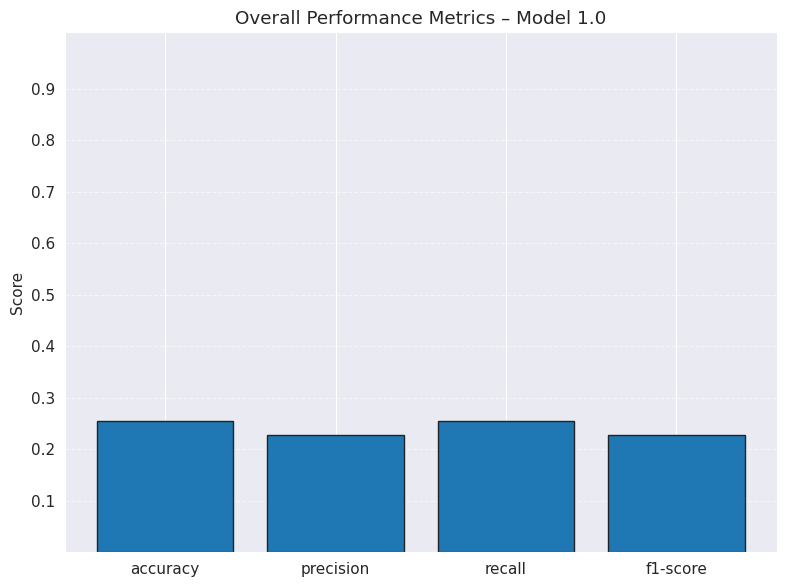

In [101]:
accuracy, precision, recall, f1_score = fit_and_get_report(model, X_train, y_train, X_test, y_test, X_val, y_val)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

# Model 1.1: Normalized data.
Advanced model trained on normalized data.

In [ ]:
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

X_train_flat = X_train.reshape(-1, NUM_FEATURES)
X_val_flat = X_val.reshape(-1, NUM_FEATURES)
X_test_flat = X_test.reshape(-1, NUM_FEATURES)

# Normalize the data by training a MinMaxScaler on the train set, and then applying it to the dataset.
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshape back
X_train = X_train_scaled.reshape(n_train, NUM_TIMESTEPS, NUM_FEATURES)
X_val = X_val_scaled.reshape(n_val, NUM_TIMESTEPS, NUM_FEATURES)
X_test = X_test_scaled.reshape(n_test, NUM_TIMESTEPS, NUM_FEATURES)

In [ ]:
model_version = "1.1"
model_name = 'Model - ' + model_version

model = create_improved_RNN_archi(model_version=model_version)

Model: "1.1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 10, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 10, 64)         │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,954 (183.41 KB)

 Trainable params: 46,954 (183.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.0881 - loss: 2.3075 - val_accuracy: 0.1000 - val_loss: 2.3004
Epoch 2/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1103 - loss: 2.3003 - val_accuracy: 0.1375 - val_loss: 2.2967
Epoch 3/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0816 - loss: 2.2992 - val_accuracy: 0.1500 - val_loss: 2.2933
Epoch 4/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1014 - loss: 2.2948 - val_accuracy: 0.1750 - val_loss: 2.2900
Epoch 5/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1278 - loss: 2.2898 - val_accuracy: 0.2000 - val_loss: 2.2866
Epoch 6/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1277 - loss: 2.2909 - val_accuracy: 0.2000 - val_loss: 2.2831
Epoch 7/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1778 - loss: 2.2820 - val_accuracy: 0.1500 - val_loss: 2.2793
Epoch 8/600
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1572 - loss: 2.2794 - val_accuracy: 0.

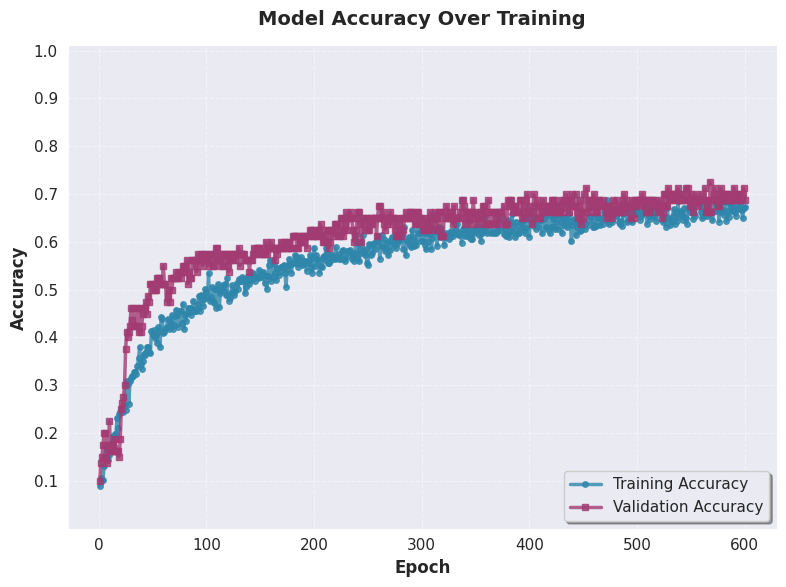

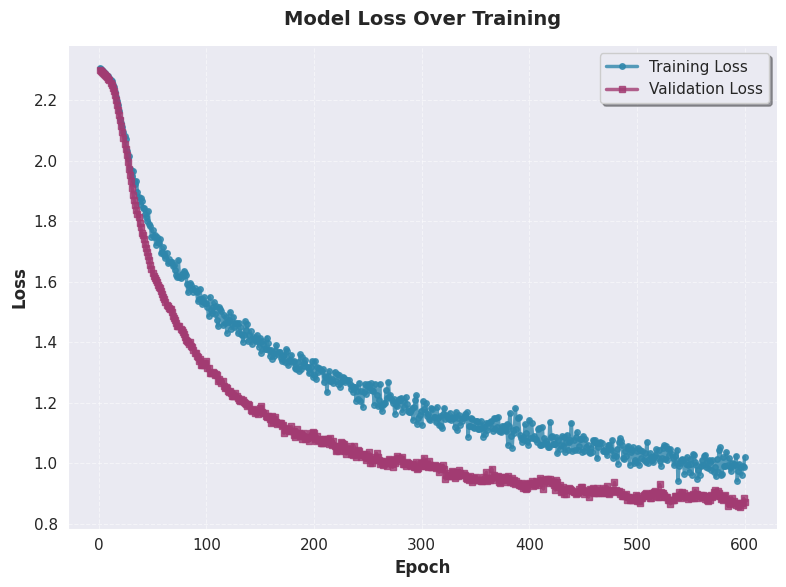

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


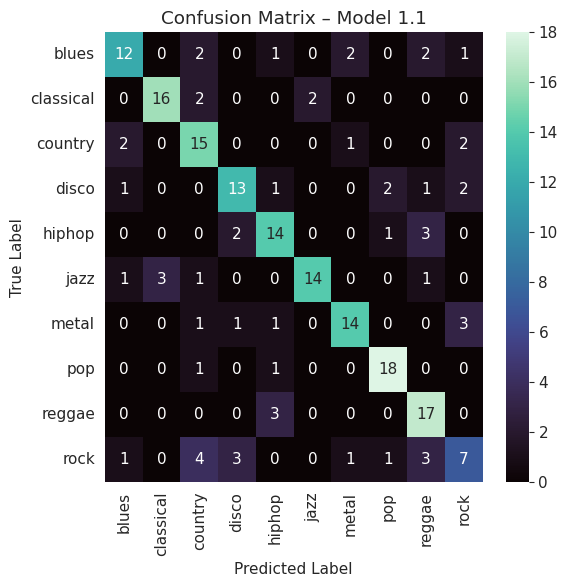

{'0': {'precision': 0.7058823529411765, 'recall': 0.6, 'f1-score': 0.6486486486486487, 'support': 20.0}, '1': {'precision': 0.8421052631578947, 'recall': 0.8, 'f1-score': 0.8205128205128205, 'support': 20.0}, '2': {'precision': 0.5769230769230769, 'recall': 0.75, 'f1-score': 0.6521739130434783, 'support': 20.0}, '3': {'precision': 0.6842105263157895, 'recall': 0.65, 'f1-score': 0.6666666666666666, 'support': 20.0}, '4': {'precision': 0.6666666666666666, 'recall': 0.7, 'f1-score': 0.6829268292682927, 'support': 20.0}, '5': {'precision': 0.875, 'recall': 0.7, 'f1-score': 0.7777777777777778, 'support': 20.0}, '6': {'precision': 0.7777777777777778, 'recall': 0.7, 'f1-score': 0.7368421052631579, 'support': 20.0}, '7': {'precision': 0.8181818181818182, 'recall': 0.9, 'f1-score': 0.8571428571428571, 'support': 20.0}, '8': {'precision': 0.6296296296296297, 'recall': 0.85, 'f1-score': 0.723404255319149, 'support': 20.0}, '9': {'precision': 0.4666666666666667, 'recall': 0.35, 'f1-score': 0.4, 's

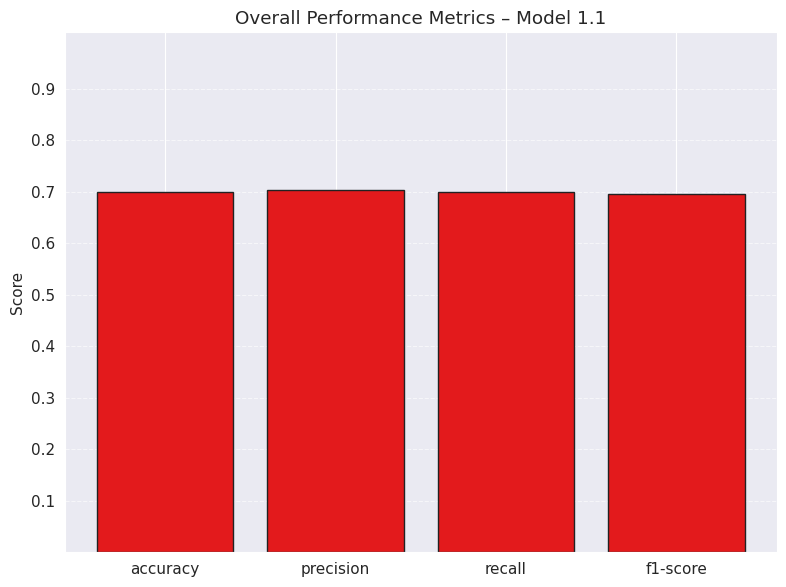

In [ ]:
accuracy, precision, recall, f1_score = fit_and_get_report(model, X_train, y_train, X_test, y_test, X_val, y_val)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

# Model 1.2: Normalized data + noise injection.
Advanced model trained on normalized data + noise injection.

In [ ]:
# Count the number of instances for each class
_, class_counts = np.unique(y, return_counts=True)

dev_stds = np.zeros((NUM_CLASSES, NUM_TIMESTEPS, NUM_FEATURES))

class_index = 0
start_index = 0
end_index = class_counts[0]

# For each class calculate std_dev
for count in class_counts:
    dev_std = np.zeros((NUM_TIMESTEPS, NUM_FEATURES))
    
    # Extract all instances of the current class from the training set
    cur_X = X_train[start_index:end_index] 
    cur_X = np.transpose(cur_X, (1, 2, 0))
    
    # For each class iterate single timesteps (10 timesteps)
    for i, timestep_X in enumerate(cur_X):
        
        # For each timestep, extract the features (57 features)
        for j, feature_X in enumerate(timestep_X):
            cur_u = 0
            cur_dev = 0

            # Compute the mean of each feature for all the instances
            for instance_feature_X in feature_X:
                cur_u = cur_u + instance_feature_X
            cur_u = cur_u / count

            # Compute std_dev of each feature
            for instance_feature_X in feature_X:
                cur_dev = cur_dev + (instance_feature_X - cur_u)**2
            cur_dev = (cur_dev / count)**0.5
            
            dev_std[i, j] = cur_dev
    
    # Save std_dev of class features
    dev_stds[class_index, :, :] = dev_std
    
    # Update the indexes
    start_index = end_index
    end_index += count
    class_index = class_index + 1

In [ ]:
# Final size of the training set = final_size*dataset_size
final_size = 2

# Allocate the needed memory
X_train_augm = np.zeros((final_size * len(X_train), NUM_TIMESTEPS, NUM_FEATURES))
y_train_augm = np.zeros((final_size * len(y_train), NUM_TIMESTEPS))

# Copy the training instances
X_train_augm[:len(X_train), :, :] = X_train
y_train_augm[:len(y_train), :] = y_train

instance_index = len(X_train)
for _ in range(final_size - 1): 
    
    # For each training instance
    for instance, genre_one_hot in zip(X_train, y_train):
        genre = np.argmax(genre_one_hot)
        
        # For each timestep in the training instance
        for i in range(NUM_TIMESTEPS):
            
            # For each feature in the timestep
            for j in range(NUM_FEATURES):
                
                dev_std = dev_stds[int(genre), i, j]
                
                # Create a new noisy instance
                random_n = random.uniform(dev_std/2, dev_std)
                random_n = random_n*random.choice([-1, 1])
                
                new_feature = instance[i, j] + random_n
                new_feature = max(new_feature, 0)
                new_feature = min(new_feature, 1)
                X_train_augm[instance_index, i, j] = new_feature
                
        y_train_augm[instance_index, :] = genre_one_hot
        instance_index = instance_index + 1

In [ ]:
model_version = "1.2"
model_name = 'Model - ' + model_version

model = create_improved_RNN_archi(model_version=model_version)

Model: "1.2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_24 (Dropout)            │ (None, 10, 57)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 10, 64)         │        31,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 10, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,954 (183.41 KB)

 Trainable params: 46,954 (183.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.0917 - loss: 2.3068 - val_accuracy: 0.1000 - val_loss: 2.2969
Epoch 2/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1245 - loss: 2.2992 - val_accuracy: 0.1125 - val_loss: 2.2885
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1353 - loss: 2.2909 - val_accuracy: 0.2500 - val_loss: 2.2787
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1762 - loss: 2.2783 - val_accuracy: 0.2625 - val_loss: 2.2662
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1889 - loss: 2.2683 - val_accuracy: 0.3000 - val_loss: 2.2491
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2261 - loss: 2.2484 - val_accuracy: 0.3250 - val_loss: 2.2241
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2159 - loss: 2.2328 - val_accuracy: 0.3625 - val_loss: 2.1908
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2763 - loss: 2.1917 - val_accuracy: 0.

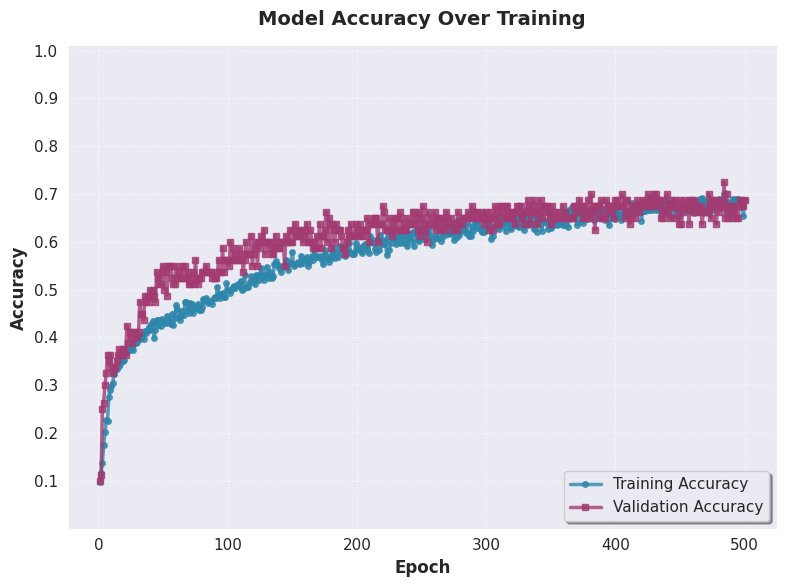

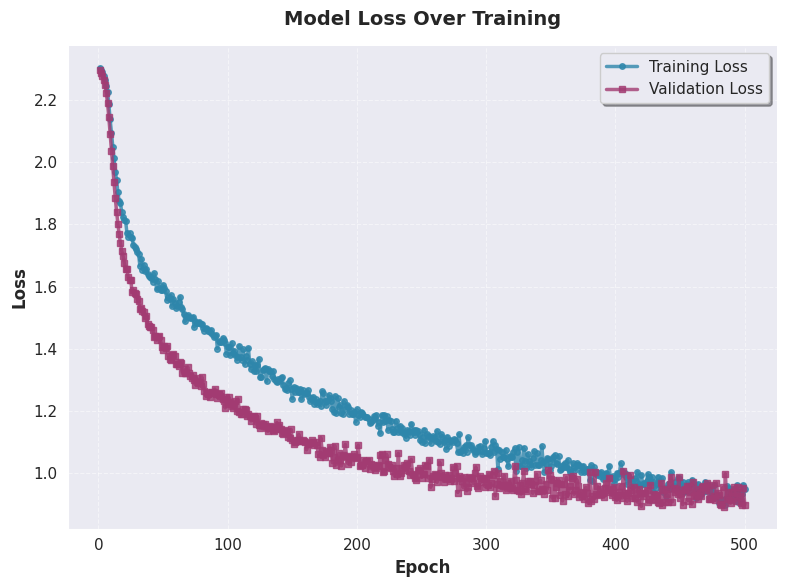

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


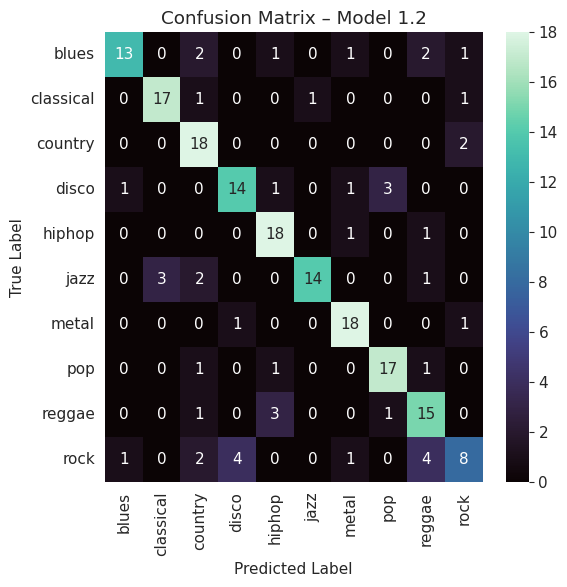

{'0': {'precision': 0.8666666666666667, 'recall': 0.65, 'f1-score': 0.7428571428571429, 'support': 20.0}, '1': {'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85, 'support': 20.0}, '2': {'precision': 0.6666666666666666, 'recall': 0.9, 'f1-score': 0.7659574468085106, 'support': 20.0}, '3': {'precision': 0.7368421052631579, 'recall': 0.7, 'f1-score': 0.717948717948718, 'support': 20.0}, '4': {'precision': 0.75, 'recall': 0.9, 'f1-score': 0.8181818181818182, 'support': 20.0}, '5': {'precision': 0.9333333333333333, 'recall': 0.7, 'f1-score': 0.8, 'support': 20.0}, '6': {'precision': 0.8181818181818182, 'recall': 0.9, 'f1-score': 0.8571428571428571, 'support': 20.0}, '7': {'precision': 0.8095238095238095, 'recall': 0.85, 'f1-score': 0.8292682926829268, 'support': 20.0}, '8': {'precision': 0.625, 'recall': 0.75, 'f1-score': 0.6818181818181818, 'support': 20.0}, '9': {'precision': 0.6153846153846154, 'recall': 0.4, 'f1-score': 0.48484848484848486, 'support': 20.0}, 'accuracy': 0.76, 'macro 

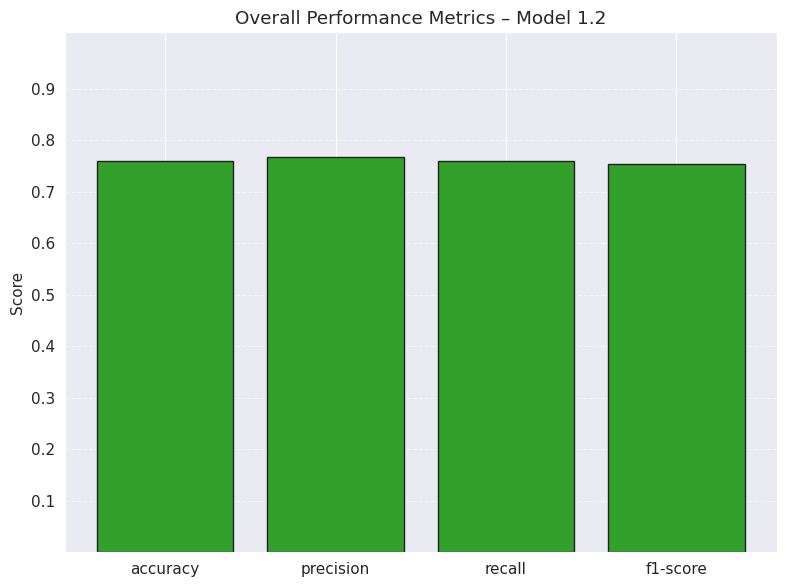

In [118]:
accuracy, precision, recall, f1_score = fit_and_get_report(model, X_train_augm, y_train_augm, X_test, y_test, X_val, y_val, epochs = 500)

# Save the performances in the dictionary
performances[model_name] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1-score': f1_score 
}

plot_overall_metrics(performances[model_name], model_version)

{'Model - 0.0': {'accuracy': 0.31, 'precision': 0.3471220889198311, 'recall': 0.31, 'f1-score': 0.3091962363107589}, 'Model - 1.0': {'accuracy': 0.255, 'precision': 0.2282542366864051, 'recall': 0.255, 'f1-score': 0.22697626681923372}, 'Model - 1.1': {'accuracy': 0.7, 'precision': 0.7043043778260497, 'recall': 0.7, 'f1-score': 0.6966095873642849}, 'Model - 1.2': {'accuracy': 0.76, 'precision': 0.7671599015020067, 'recall': 0.76, 'f1-score': 0.7548022942288639}}


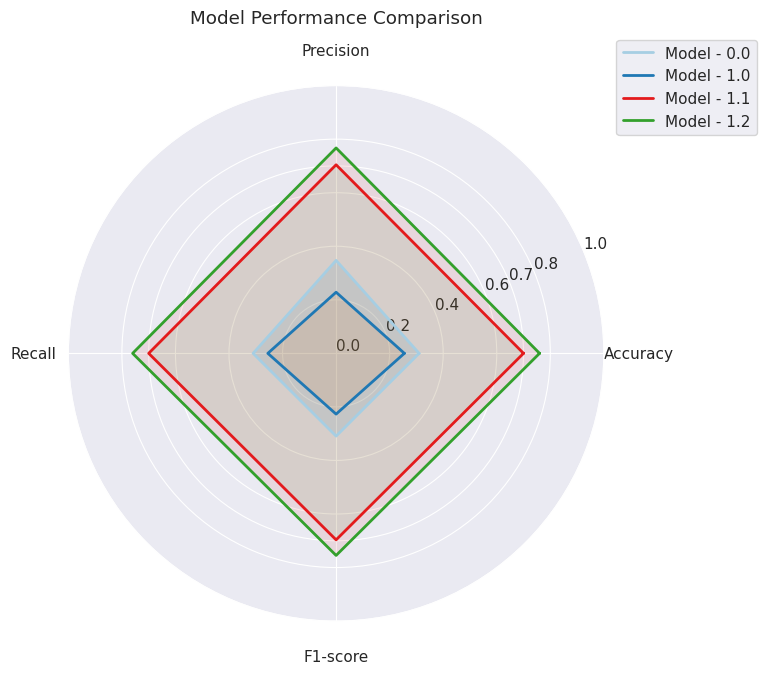

In [ ]:
print(performances)
plot_model_performance_radar(performances)

In [ ]:
#model.save('/kaggle/working/RNN.keras')